# Most Upvoted Words on /r/politics

### Written by Brendan Colón on June 15, 2016

One of the most interesting datasets on Kaggle now is a portion of a larger dataset comprising every comment ever made on Reddit. Here, I'll be looking at all comments made during May, 2015 to search for words that tend to result in a lot of upvotes (or downvotes) if they appear once in a comment. I chose to start this analysis with /r/politics as part of a larger, longitudinal study of this subreddit to the current day. 

First, let's start off by importing everything. The aesthetic stuff here is courtesy of Harvard's CS109 course.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
import sqlite3

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

Next, let's turn everything from /r/politics into a dataframe. 

In [2]:
con = sqlite3.connect("reddit_comments.sqlite")
politics_df = pd.read_sql_query("SELECT * from May2015 WHERE subreddit = 'politics'", con)

How I divide the data here into "high upvotes" and "low upvotes" is fairly arbitrary. The key issue here is that many comments get 1 upvote by default and stay that way for several reasons. One explanation is that someone commented on a "dead" thread that nobody is looking at anymore. Another explanation is that a comment was made in a large thread, put on the bottom, and then never read. I'm going to pick my "low upvotes" category as comments that have received a negative net upvote score to ensure they were looked at least looked at. Below, I plot my thresholds with red lines. 

--- Mean is 5.38699694195
--- Median is 1.0
--- Standard Deviation is 40.7522302602


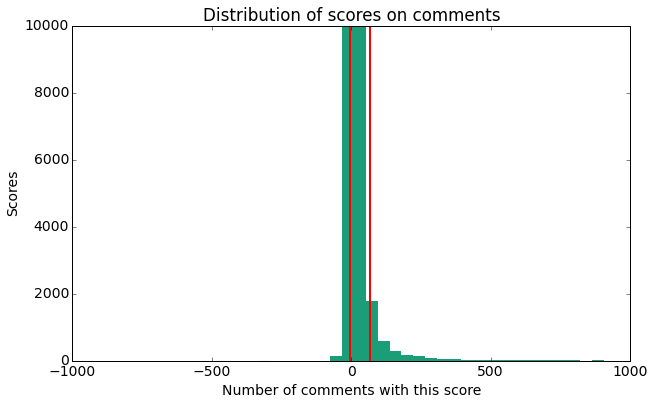

In [44]:
plt.hist(politics_df.score, bins=100)
plt.ylim([0,10000])
plt.xlim([-1000,1000])
plt.title('Distribution of scores on comments')
plt.ylabel('Scores')
plt.xlabel('Number of comments with this score')
plt.axvline(np.mean(politics_df.score)-0.2*np.std(politics_df.score), c='r')
plt.axvline(np.mean(politics_df.score)+1.5*np.std(politics_df.score), c='r')

print "--- Mean is " + str(politics_df.score.mean())
print "--- Median is " + str(politics_df.score.median())
print "--- Standard Deviation is " + str(np.std(politics_df.score))

Now for the analysis pipeline. First, I'll upload a .txt file containing common words in the English language. These words are probably not very interesting and will likely appear as they're essentially "background" to English. Next, I'll clean the dataset to make sure the text encoding is compatible with the dataframe to not get gibberish. I'll then convert my dataframe into X's and Y's.

In [4]:
#common words
frequent_words = open('common_words.txt', 'r')
common = frequent_words.read()
common = common.split('\n')

def clean_pandas(df):
    """Sets up the X and Y columns for learning"""
    
    cols = ['score', 'body']
    df = df[cols]
    df = df[df.body != "[deleted]"] #a lot of comments are removed, let's take these out
    
    ascii_encoding = [] #make sure that encoding is correct to remove weird symbols
    for i in df.body.tolist():
        ascii_encoding.append( i.encode('ascii', 'ignore') )
    df.body = ascii_encoding
    
    #setup df to split data by stds away from mean in both directions
    avg_out = df[df.score < np.mean(df.score)-0.5*np.std(df.score)]
    high_out = df[df.score > np.mean(df.score)+1.5*np.std(df.score)]

    avg_out.score = 0
    high_out.score = 1
    df = pd.concat([avg_out, high_out])
    return df

def make_xy_comments(df, vectorizer):
    df = clean_pandas(df)
    if vectorizer==None:
        vectorizer = CountVectorizer(min_df=0.0001,
                                     token_pattern=ur'[a-z]{3,}', #removes words with numbers, 1-2 letter words
                                     stop_words=common) #removes frequent words in English
    vectorizer.fit(df.body)
    x = vectorizer.transform(df.body)
    
    #make an array of number of citations for each paper
    y=np.array(df.score) #dtype="|S6"
    
    #convert the sparse array from COO format to CSC format
    x = x.tocsc()
    return x,y

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

def cv_score(clf, x, y, score_func):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [7]:
vectorizer = CountVectorizer(token_pattern=ur'[a-z]{3,}',
                            stop_words=common) #uses optimized min_df

X, Y = make_xy_comments(politics_df, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)

clf = MultinomialNB().fit(xtrain, ytrain) #uses unoptimized alpha

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print '------- Accuracy on Unoptimized Hyperparameters -------'
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

------- Accuracy on Unoptimized Hyperparameters -------
Accuracy on training data: 0.92
Accuracy on test data:     0.74


So with no parameters tuned we're quite a bit overfit. I played with the min_df and alpha parameters a bit. min_df is the minimal occurences of a word necessary to show up for it to be considered in this model and alpha is a smoothing parameter. To visualize how my model is doing over the distribution of high upvote probabilities,  I'm going to use a calibration plot.

In [48]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome), dtype=float)

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(High Upvotes)")
    remove_border(ax)
    
    #the distribution of P(High Upvotes)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(High Upvotes)")
    remove_border()
    plt.ylabel("Number")

After playing with the parameters, this is what I got...

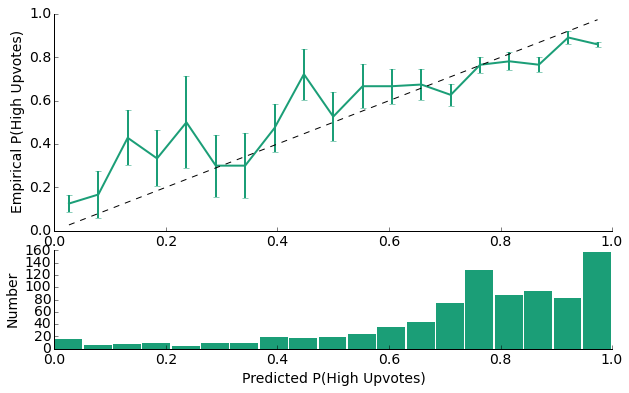

In [49]:
vectorizer = CountVectorizer(min_df = 0.0075, ngram_range=(1,2), #this does allow bigrams!
                             token_pattern=ur'[a-z]{3,}',
                            stop_words=common)

X, Y = make_xy_comments(politics_df, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)

clf = MultinomialNB(alpha=2).fit(xtrain, ytrain)

calibration_plot(clf, xtest, ytest)

In [50]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print '------- Accuracy on Tuned Hyperparameters -------'
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.80
Accuracy on test data:     0.74


Not pefect but much much better. Now, let's see what words tend to appear in comments that score great and poorly in the /r/politics community.

In [51]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print "Good words\t     P(High Upvotes | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
print "Bad words\t     P(Low Upvotes | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % (1 - np.exp(p))

Good words	     P(High Upvotes | word)
              prison 0.95
         legislation 0.93
        corporations 0.93
               raise 0.93
                seen 0.92
         information 0.92
                 won 0.92
              senate 0.91
           wikipedia 0.91
            congress 0.91
Bad words	     P(Low Upvotes | word)
              months 0.57
               blame 0.54
             liberal 0.53
           democrats 0.53
               sorry 0.51
               women 0.50
             illegal 0.48
              please 0.44
              global 0.40
            liberals 0.20


This model appears to be much better at pulling out words that are upvoted more than words that tend to be downvoted. The other case is that there isn't much difference in words that don't score highly. That being said, it does look like the word 'liberals' is a pretty good predictor of a comment that will get downvoted. Prison, legislation, and corporations are the three highest predictors of a upvoted comment.

Now let's tweak the functions slightly and do this on every month starting arbitrarily from January 2015. I used the Reddit comment source on Google Bigquery to pull this out and turn it into a giant .csv

In [120]:
rpolitics = pd.read_csv('politics_dataset/rpolitics_2015-2016.csv')

The following functions are slightly different to account for a larger dataset with a few more issues.

In [233]:
dates = ['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
         '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
         '2016-01', '2016-02', '2016-03', '2016-04']

def clean_large_pandas(df, month):
    """Sets up the X and Y columns for learning but also splits the large Reddit dataset """
    
    df = df[(df['created_utc'] >= str(month) + '-00') 
                 & (df['created_utc'] <= str(month) + '-99')]
    
    cols = ['score', 'body']
    df = df[cols]
    df = df[df.body != "[deleted]"] #a lot of comments are removed, let's take these out
    
    ascii_encoding = [] #make sure that encoding is correct to remove weird symbols
    #for i in df.body.tolist():
    #    ascii_encoding.append( i.encode('ascii', 'ignore') )
    #df.body = ascii_encoding
    
    #setup df to split data by stds away from mean in both directions
    avg_out = df[df.score < np.mean(df.score)-0.5*np.std(df.score)]
    high_out = df[df.score > np.mean(df.score)+1.5*np.std(df.score)]

    avg_out.score = 0
    high_out.score = 1
    df = pd.concat([avg_out, high_out])
    return df

def make_large_xy_comments(df, vectorizer):
    if vectorizer==None:
        vectorizer = CountVectorizer(min_df=0.0001,
                                     token_pattern=ur'[a-z]{3,}', #removes words with numbers, 1-2 letter words
                                     stop_words=common) #removes frequent words in English
        
    df = df.dropna() #removes some of the nan values that stop analysis
    vectorizer.fit(df.body)
    x = vectorizer.transform(df.body)
    
    #make an array of number of citations for each paper
    y=np.array(df.score) #dtype="|S6"
    
    #convert the sparse array from COO format to CSC format
    x = x.tocsc()
    return x,y

def retrieve_significant_words(df, vectorizer):
    '''Given a df and vectorizer will collect the top 10 words for a certain year'''
    X,Y = make_large_xy_comments(df,vectorizer)
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)
    clf = MultinomialNB(alpha=2).fit(xtrain, ytrain)    
    
    #create an identity array with the same dimensions as X
    ident = np.eye(X.shape[1])
    
    #compute the probabilities of being upvoted
    probs = clf.predict_proba(ident)
    cited = probs[:,1]
    
    #get the list of words from the vectorizer function
    words = vectorizer.get_feature_names()
    
    #zip the words to the probabilities so they can be sorted together
    zipped = zip(cited,words)
    zipped = sorted(zipped,reverse=True)
    
    #unzip the array but keep them sorted
    probs, words = zip(*zipped)
    
    #make the results look nice by saving in a dataframe
    #assume that each word appears one time
    top_words = pd.DataFrame(dict(word=words[:10],prob_cited=probs[:10]))
    bottom_words = pd.DataFrame(dict(word=words[-10:],prob_cited=probs[-10:]))
    
    #print out numbers on training set vs. test
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)

    print '------- Accuracy on Tuned Hyperparameters -------'
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print '-------------------------------------------------'
    
    #return the buzzwords and the fit object
    return top_words, bottom_words, clf

Next, I'll throw all the best predictors of high and low upvote scores in their own dictionaries and print out the scores of each model. Unfortunately, the models in some years aren't as powerful as others. 

In [235]:
top_words = dict()
bottom_words = dict()

vectorizer = CountVectorizer(min_df = 0.0075, ngram_range=(1,2), #this does allow bigrams!
                             token_pattern=ur'[a-z]{3,}',
                             stop_words=common)

for month in dates:
    print "Month is " + str(month)
    df = clean_large_pandas(rpolitics, month)
    X,Y = make_large_xy_comments(df, vectorizer)
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)
    clf = MultinomialNB(alpha=2).fit(xtrain, ytrain) 
    
    #retrive words and put them into dictionary
    top_words[month], bottom_words[month],_ = retrieve_significant_words(df, vectorizer)

Month is 2015-01
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.76
Accuracy on test data:     0.69
-------------------------------------------------
Month is 2015-02
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.75
Accuracy on test data:     0.68
-------------------------------------------------
Month is 2015-03
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.78
Accuracy on test data:     0.74
-------------------------------------------------
Month is 2015-04
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.79
Accuracy on test data:     0.73
-------------------------------------------------
Month is 2015-05
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0.81
Accuracy on test data:     0.72
-------------------------------------------------
Month is 2015-06
------- Accuracy on Tuned Hyperparameters -------
Accuracy on training data: 0

Now I'm going to fashion each of the top and bottom words in their own dataset with their scores from before and after they "peak".

In [296]:
#grabs the top words of all years to do longitudinal analysis
top_words_index = []
for i in top_words.itervalues():
    for j in i.word.values:
        top_words_index.append(j)
top_words_index = list(set(top_words_index))

bottom_words_index = []
for i in bottom_words.itervalues():
    for j in i.word.values:
        bottom_words_index.append(j)
bottom_words_index = list(set(bottom_words_index))

In [299]:
monthly_scores_master_upvotes = []
monthly_scores_master_downvotes = []

for month in dates:
    print '-------Month is ' + str(month) + '-------'
    monthly_scores_upvotes = []
    monthly_scores_downvotes = []
    df = clean_large_pandas(rpolitics, str(month))
    X,Y = make_large_xy_comments(df, vectorizer)
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)
    clf = MultinomialNB(alpha=2).fit(xtrain, ytrain) 
    
    for word in top_words_index:
        monthly_scores_upvotes.append( 
            clf.predict_proba(vectorizer.transform([str(word)]))[0][1] )
    monthly_scores_master_upvotes.append( monthly_scores_upvotes )
    
    for word in bottom_words_index:
        monthly_scores_downvotes.append( 
            clf.predict_proba(vectorizer.transform([str(word)]))[0][0] )
    monthly_scores_master_downvotes.append( monthly_scores_downvotes )

-------Month is 2015-01-------
-------Month is 2015-02-------
-------Month is 2015-03-------
-------Month is 2015-04-------
-------Month is 2015-05-------
-------Month is 2015-06-------
-------Month is 2015-07-------
-------Month is 2015-08-------
-------Month is 2015-09-------
-------Month is 2015-10-------
-------Month is 2015-11-------
-------Month is 2015-12-------
-------Month is 2016-01-------
-------Month is 2016-02-------
-------Month is 2016-03-------
-------Month is 2016-04-------


In [307]:
longit_top_words = dict()
longit_bottom_words = dict()

for i in range(len(dates)):
    longit_top_words[dates[i]] = monthly_scores_master_upvotes[i]
    longit_bottom_words[dates[i]] = monthly_scores_master_downvotes[i]

Turn into a Dataframe and then save.

In [312]:
longit_upvotes_df = pd.DataFrame(longit_top_words, index=top_words_index)
longit_downvotes_df = pd.DataFrame(longit_bottom_words, index=bottom_words_index)

#longit_upvotes_df.to_csv("longit_upvotes.csv")
#longit_downvotes_df.to_csv("longit_downvotes.csv")

And now to plot this out for each month! Be warned: I 1) reversed the predictive scores on negative words so a higher predictive power means a comment is more likely to score negatively and negative predictors aren't very strong in this dataset. If a word's predictive power is near 0.50 it essentially means nothing. 

In [394]:
def plot_words(df, date, line_location):
    chart = df.loc[df[date].nlargest(10).index].T
    ax = chart.plot()

    # Shink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.2, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=11)
    plt.axvline(x=line_location, c='black')
    #plt.vlines(2000, 0, 1, colors='k')
    plt.ylim([0,1])
    plt.title('Predictive power of words in comments: '+str(month),fontsize=15)
    plt.xlabel('Year-Month')
    plt.ylabel("Word's predictive power")

###Best Predictors of Highly Upvoted Comments

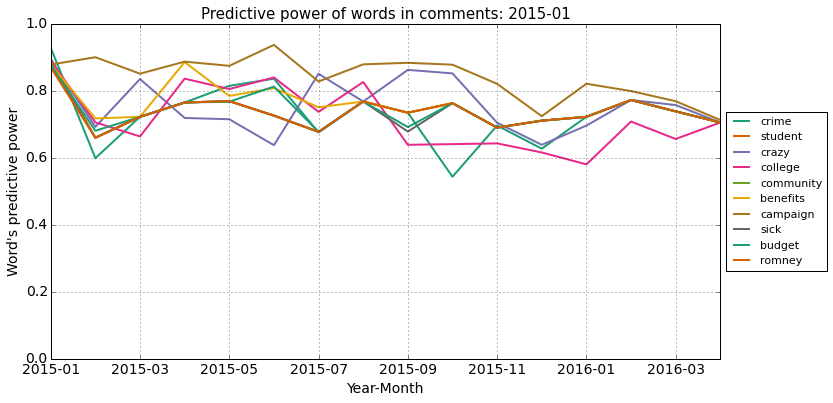

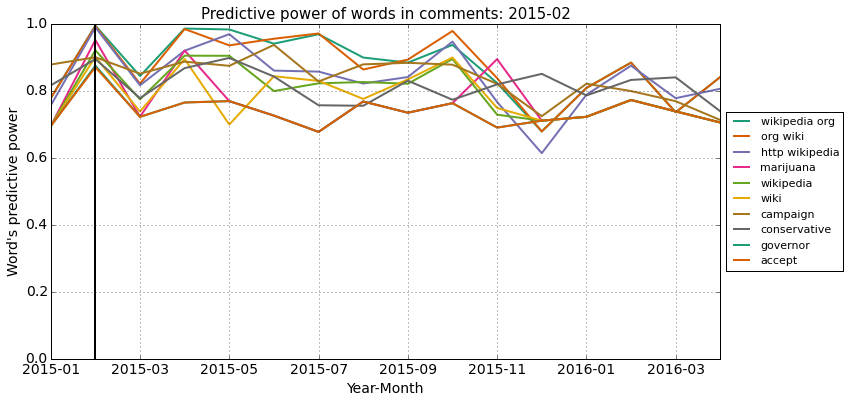

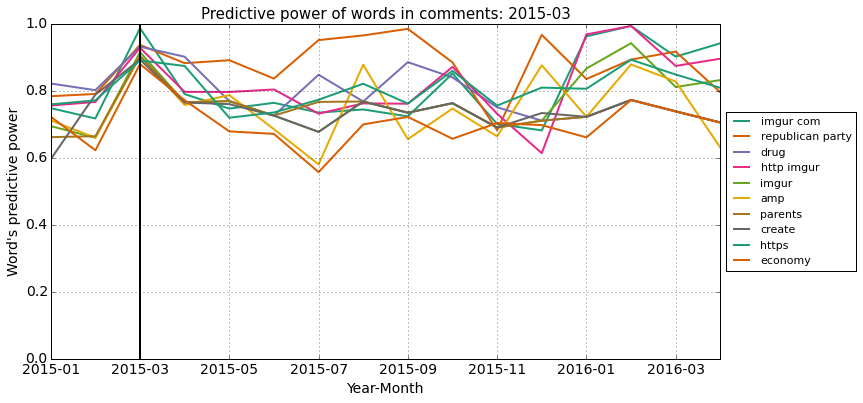

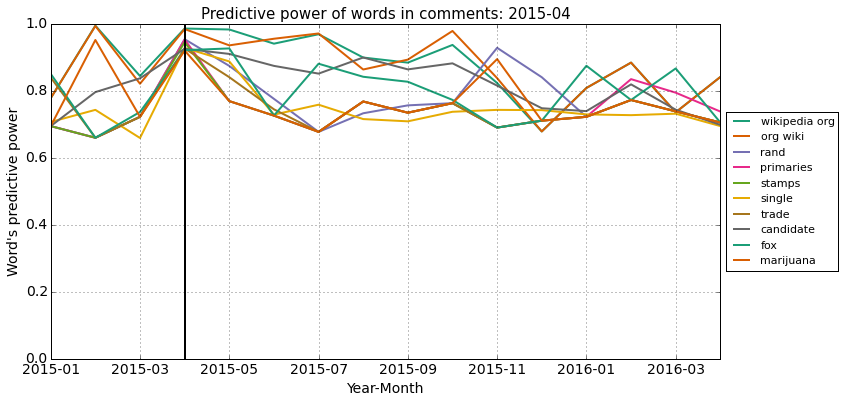

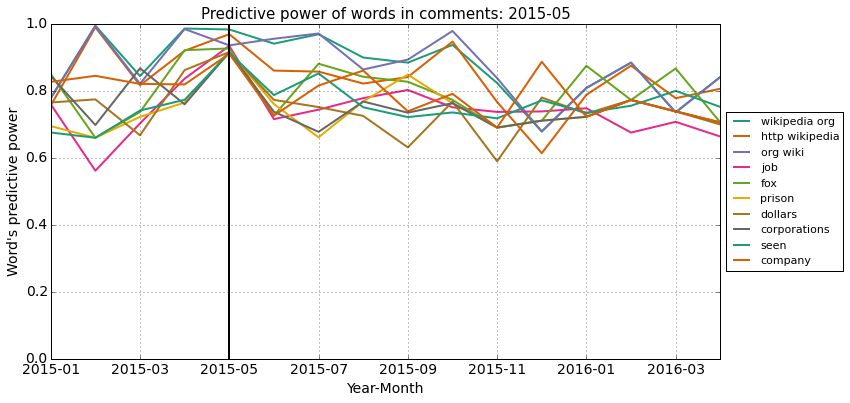

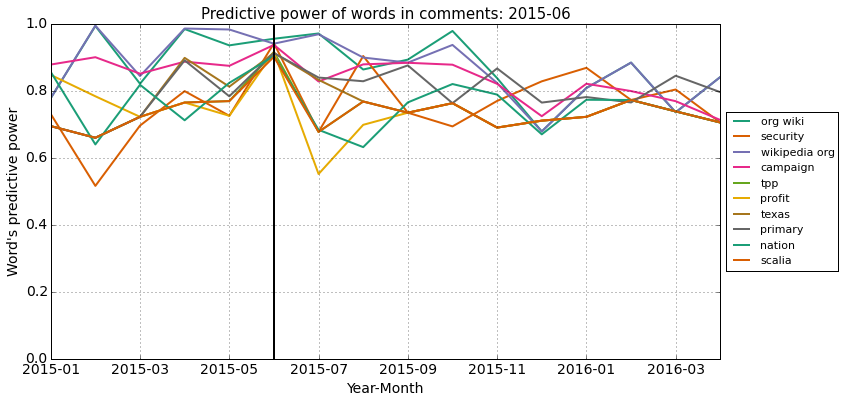

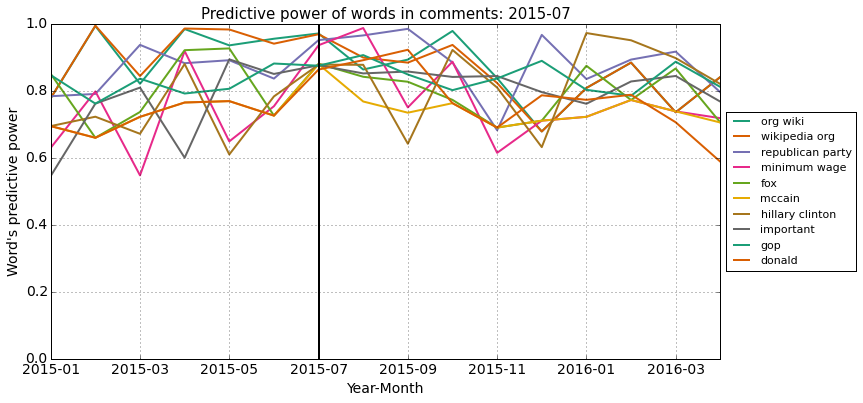

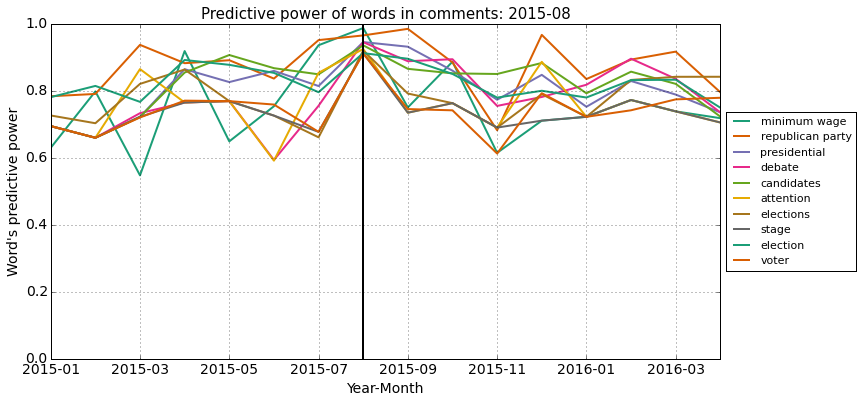

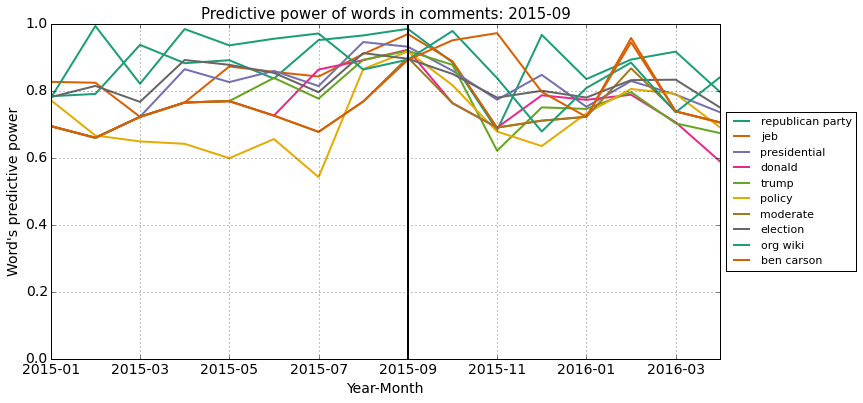

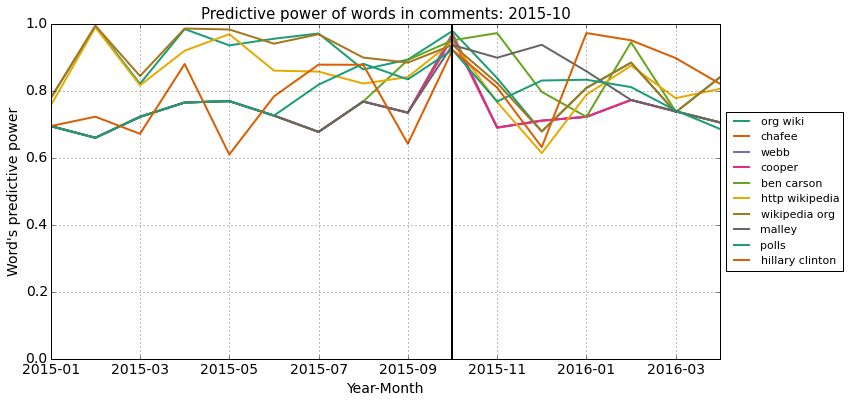

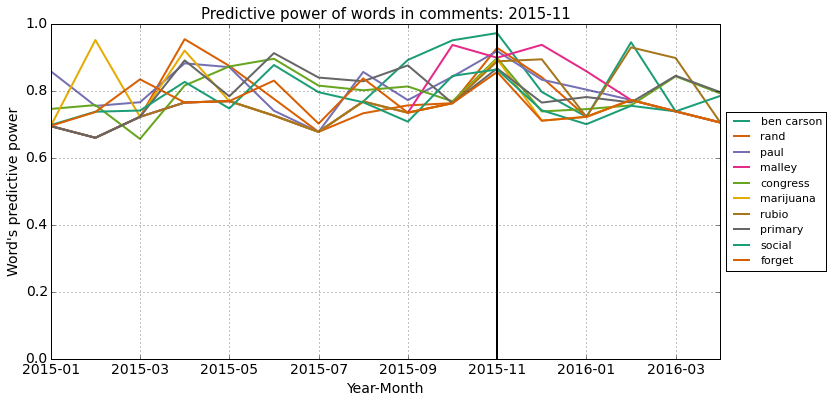

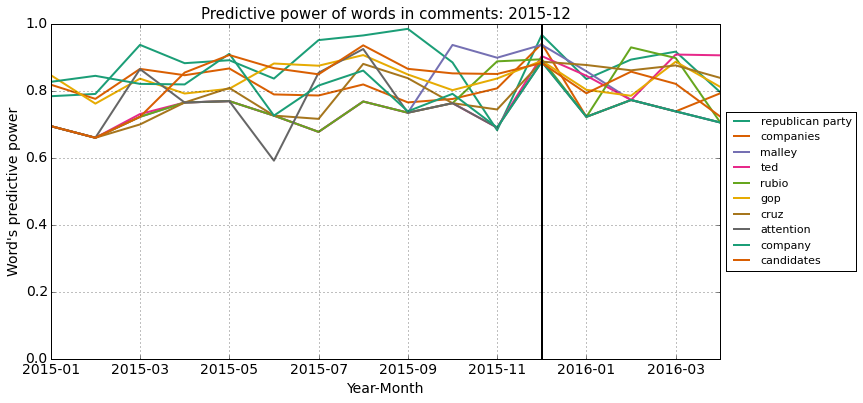

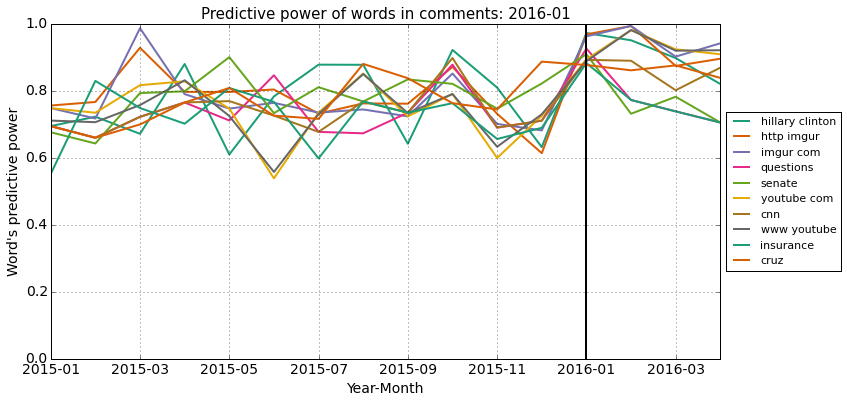

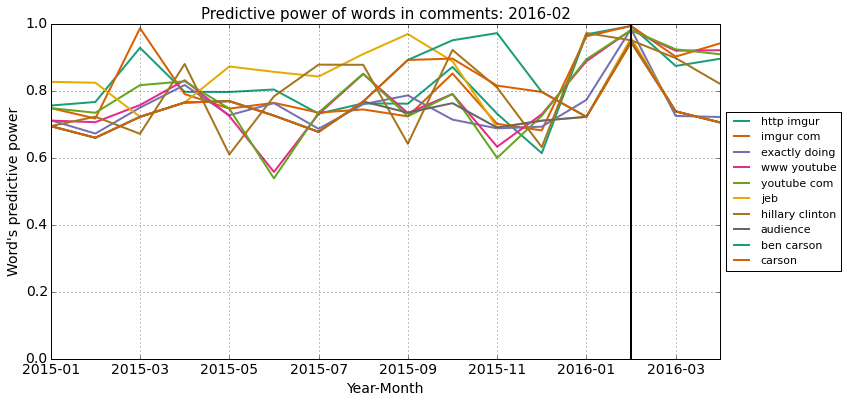

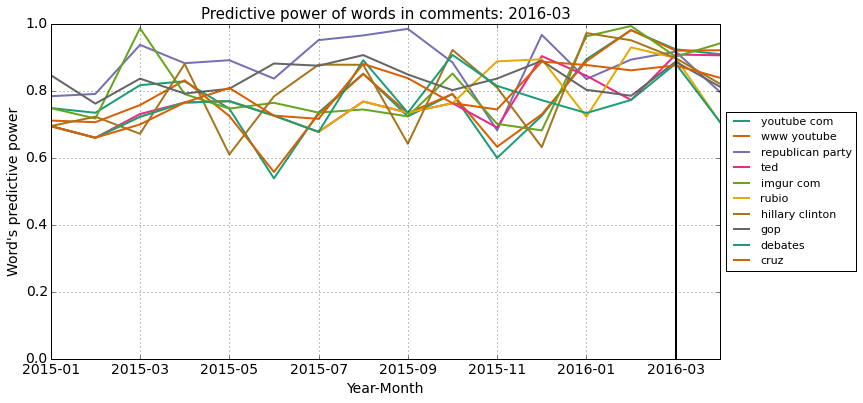

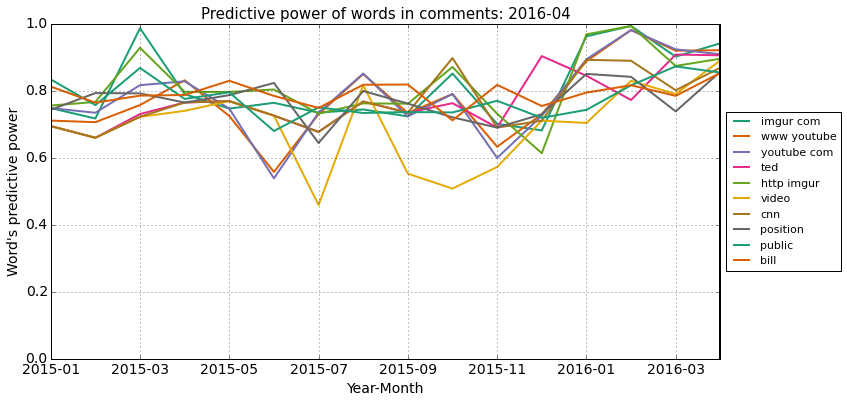

In [395]:
for i in range(len(dates)):
    month = dates[i]
    plt.figure(i)
    plot_words(longit_upvotes_df, month, i)

###Best Predictors of Highly Downvoted Comments

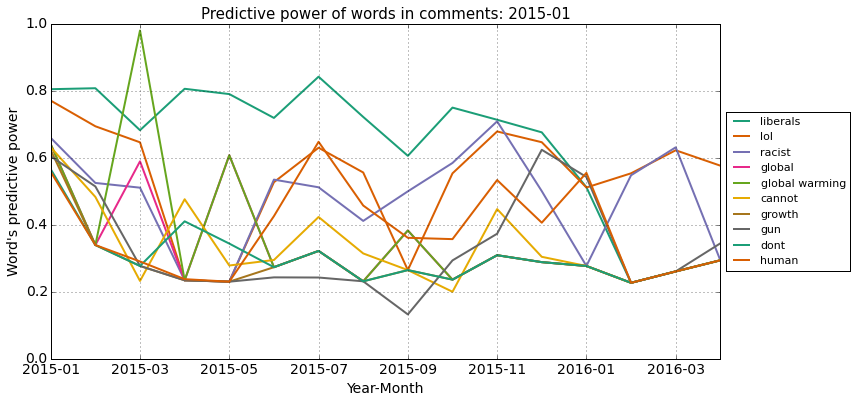

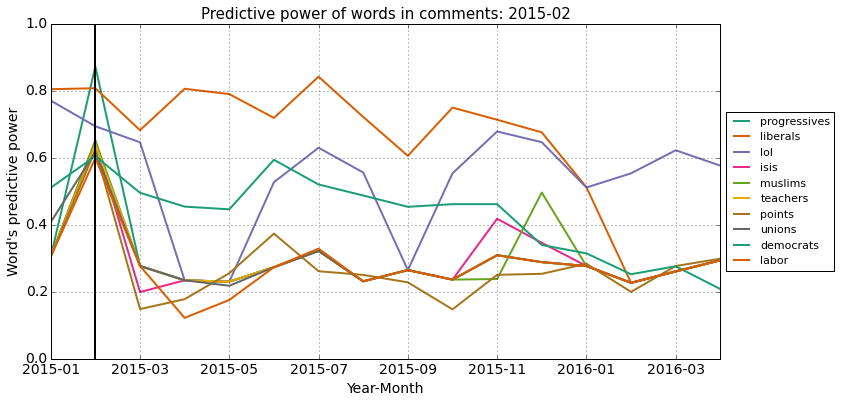

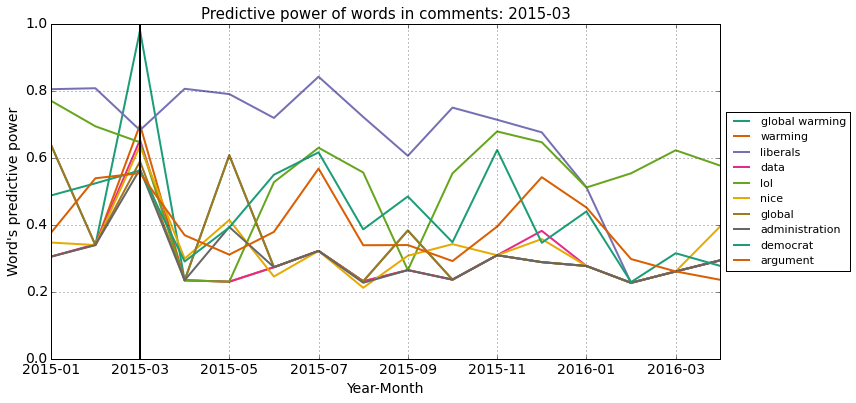

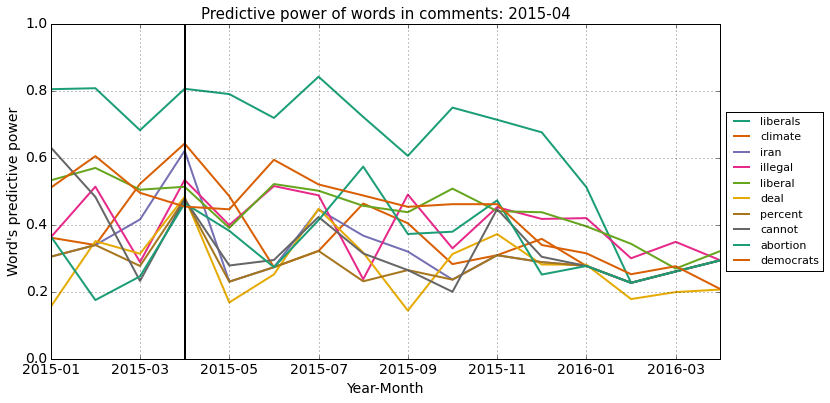

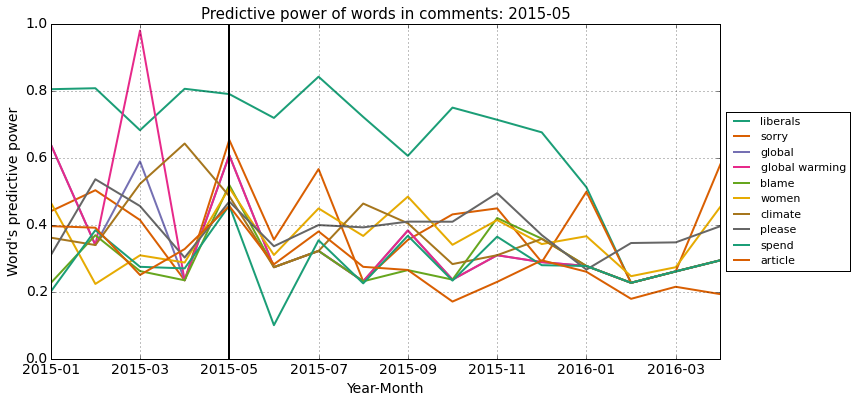

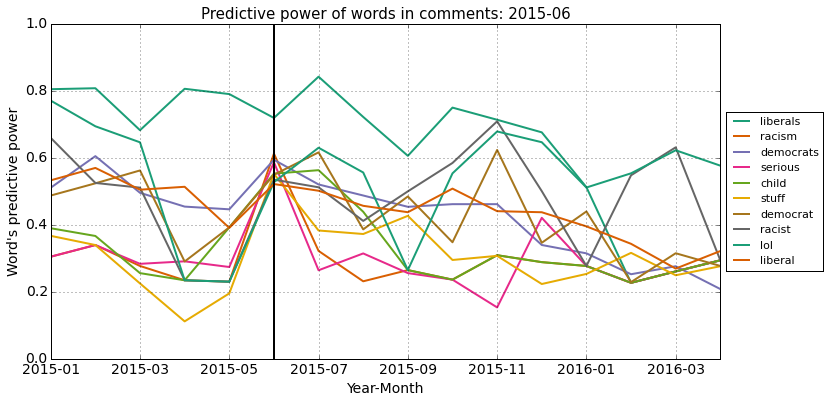

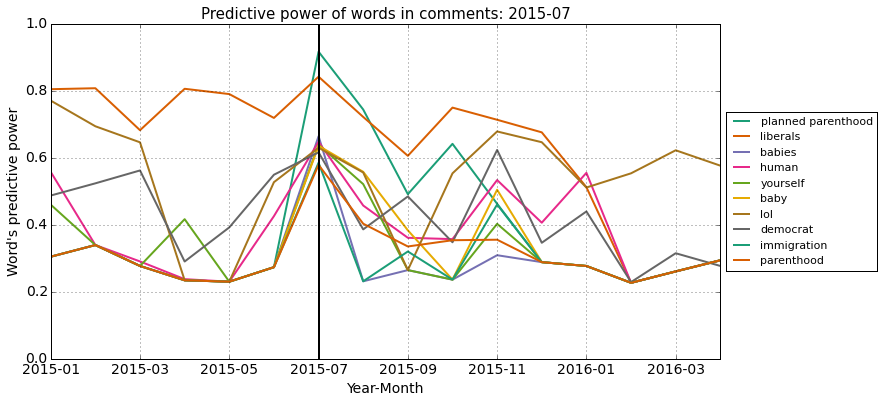

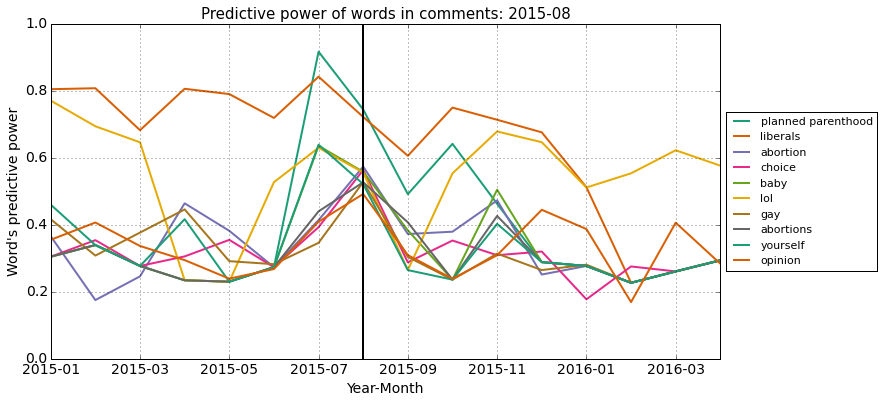

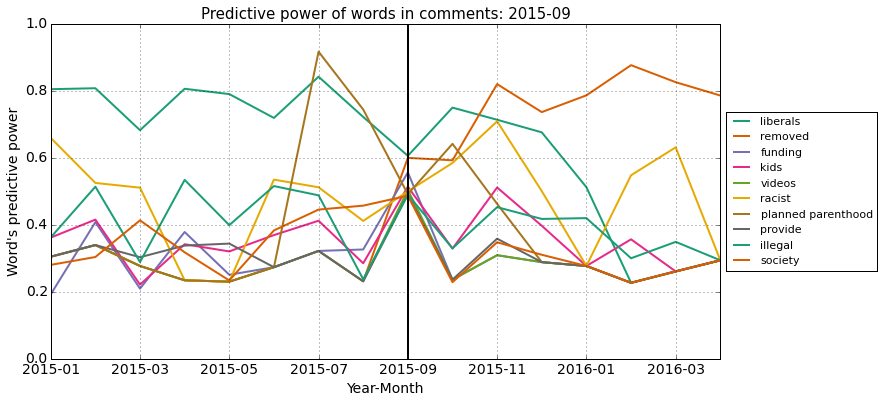

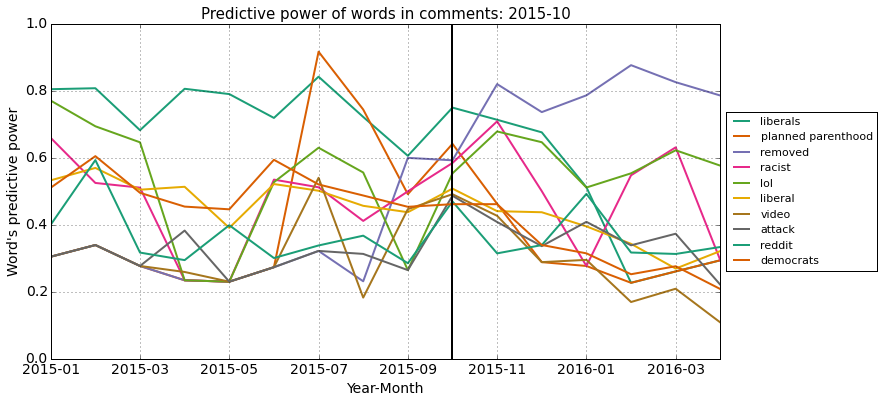

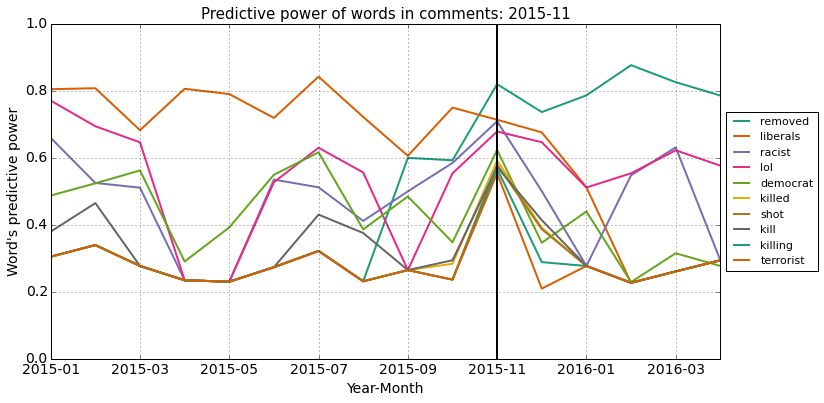

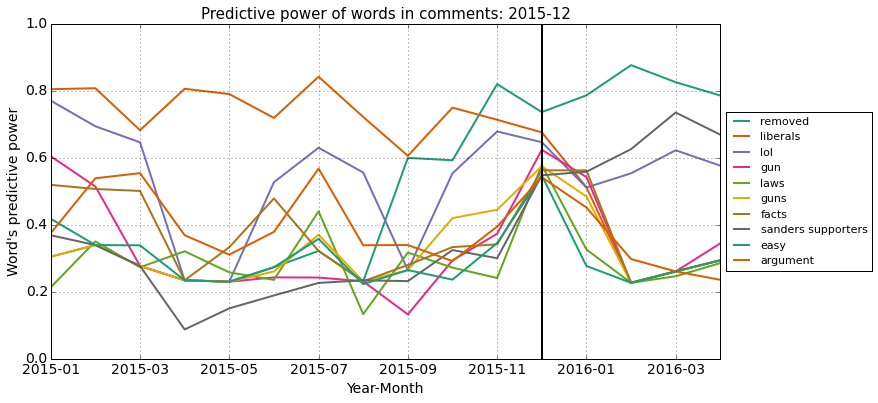

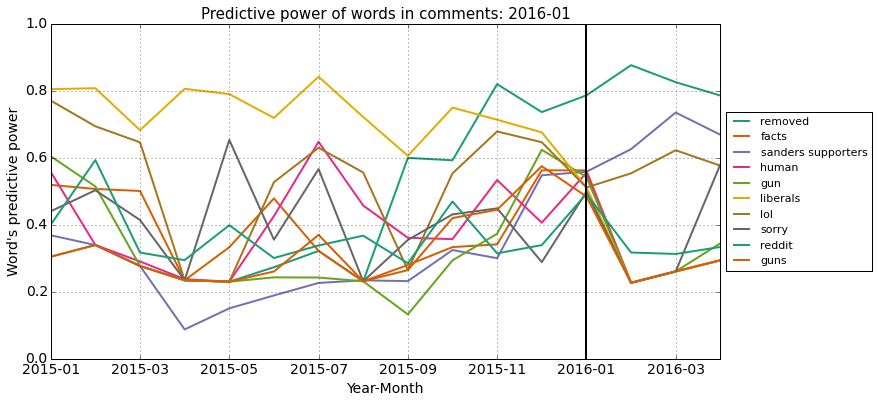

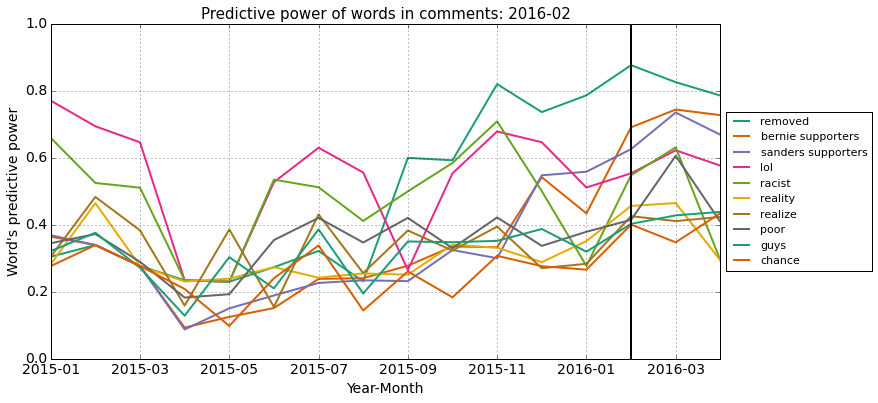

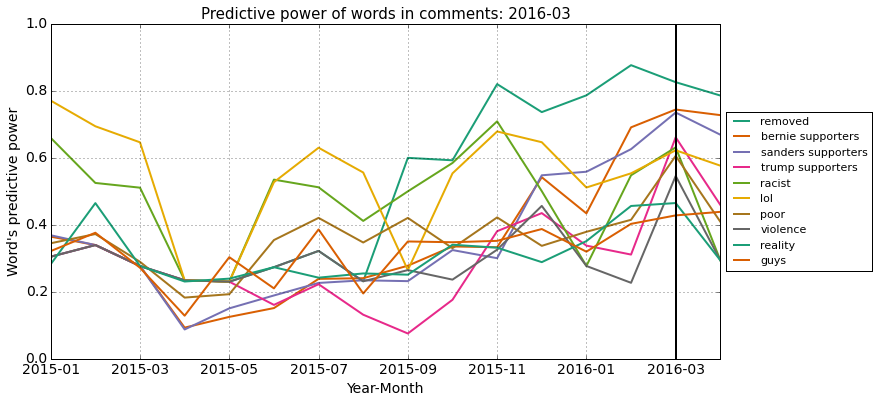

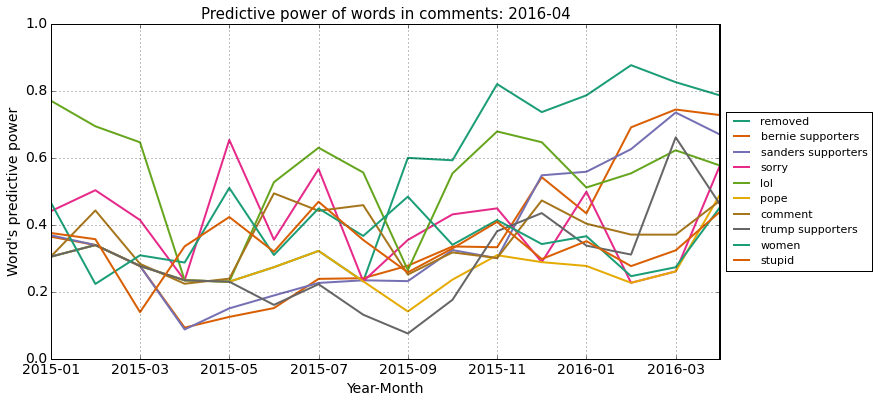

In [397]:
for i in range(len(dates)):
    month = dates[i]
    plt.figure(i)
    plot_words(longit_downvotes_df, month, i)